In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.keras import layers, models, losses, metrics
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K
import scipy
from keras.callbacks import EarlyStopping

In [ ]:
def low_pass_filter(voltages, window_size=100):
    """Applies a moving average low-pass filter to a 1D array of voltages."""
    # Create a windowed version of the array
    window = np.ones(window_size) / window_size
    filtered_voltages = np.convolve(voltages, window, mode='same')
    return filtered_voltages

# def scale(array,lead_inx):
#     array = np.nan_to_num(array, nan=0.0)  # Replace NaN values with 0.0
#     array = low_pass_filter(array, window_size=100)
#     max = [ 5153.48,  5147.37 , 3908.37 , 2847.43 , 3460.35 , 3234.22, 25391.83, 31729.22, 20077.78, 29017.36, 32767.  , 32767.  ]
#     min = [ -4226.35,  -3614.92 , -3673.21 , -5149.02 , -4047.15 , -3615.1,  -27620.79 ,-22963.18 ,-32209.77, -31848.94, -32768.,   -32768.  ]
#     a_min = min[lead_inx]
#     a_max = max[lead_inx]
#     array = np.array((array - a_min) / (a_max - a_min)) #scale
#     return array

def scale(array):
    array = np.nan_to_num(array, nan=0.0)  # Replace NaN values with 0.0
    array = low_pass_filter(array, window_size=100)

    mean = np.mean(array)
    std = np.std(array)
    if std == 0:
        # Handle the case where all elements in the array are the same
        array = np.zeros_like(array)
    else:
        array = np.array((array - mean) / std)

    a_min = np.amax(array)
    a_max = np.amin(array)
    if a_max - a_min == 0:
        # Handle the case where all elements in the normalized array are the same
        array = np.zeros_like(array)
    else:
        array = np.array((array - a_min) / (a_max - a_min))
    return array

In [ ]:
X_train = np.load('/content/drive/MyDrive/batchs/X_train1.npy')
X_train = X_train.astype(np.float32)
y_train = np.load('/content/drive/MyDrive/batchs/y_train1.npy')

In [ ]:
X_val = np.load('/content/drive/MyDrive/batchs/X_val.npy')
X_val = X_val.astype(np.float32)
y_val = np.load('/content/drive/MyDrive/batchs/y_val.npy')

In [ ]:
for i, sample in enumerate(X_train):
    for j, lead in enumerate(X_train[i]):
        X_train[i][j] = scale(lead)
X_train = np.transpose(X_train, axes=(0, 2, 1))

for i, sample in enumerate(X_val):
    for j, lead in enumerate(X_val[i]):
        X_val[i][j] = scale(lead)
X_val = np.transpose(X_val, axes=(0, 2, 1))

In [ ]:
# Define the CNN model with entropy features block architecture
def entropy_cnn_model(input_shape, num_classes):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # First branch - Convolutional layers for ECG signal
    conv1 = layers.Conv1D(16, kernel_size=3, activation=tf.nn.leaky_relu)(inputs)
    conv2 = layers.Conv1D(32, kernel_size=3, activation=tf.nn.leaky_relu)(conv1)
    conv3 = layers.Conv1D(64, kernel_size=3, activation=tf.nn.leaky_relu)(conv2)
    # conv4 = layers.Conv1D(256, kernel_size=3, activation=tf.nn.leaky_relu)(conv3)
    # conv5 = layers.Conv1D(512, kernel_size=3, activation=tf.nn.leaky_relu)(conv4)
    flatten1 = layers.Flatten()(conv3)

    # Second branch - Entropy computation
    entropy = tf.reduce_sum(-tf.math.multiply(inputs, tf.math.log(inputs + 1e-8)), axis=1)
    entropy = tf.expand_dims(entropy, axis=-1)
    flatten2 = layers.Flatten()(entropy)

    # Concatenate and flatten the results from both branches
    concatenated = layers.Concatenate()([flatten1, flatten2])

    # Fully connected layer
    dense1 = layers.Dense(256, activation=tf.nn.leaky_relu)(concatenated)

    # Output layer
    outputs = layers.Dense(num_classes, activation="sigmoid")(dense1)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
# usage
input_shape = (5000, 12)  # input shape for ECG signal (time steps, channels)
num_classes = 12  # Number of output classes
model = entropy_cnn_model(input_shape, num_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5000, 12)]   0           []                               
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 5000, 12)    0           ['input_3[0][0]']                
 mbda)                                                                                            
                                                                                                  
 tf.math.log_2 (TFOpLambda)     (None, 5000, 12)     0           ['tf.__operators__.add_2[0][0]'] 
                                                                                                  
 tf.math.multiply_2 (TFOpLambda  (None, 5000, 12)    0           ['input_3[0][0]',          

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss='binary_crossentropy',
              metrics=[
                  [tf.keras.metrics.BinaryAccuracy(name='accuracy', dtype=None, threshold=0.5)
                  , metrics.Recall(name='Recall')
                  ,metrics.Precision(name='Precision')]
                       ]
                      )

In [ ]:
from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import custom_object_scope

model = load_model('/content/drive/MyDrive/model/ecg_model3.h5')

In [ ]:
early_stop = EarlyStopping(monitor='val_Recall', patience=6,mode='max', restore_best_weights=True,verbose=1)

In [ ]:
history_1 = model.fit(X_train, y_train,
                      batch_size=32,
                      epochs=100,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stop])

Epoch 1/100
172/172 [==============================] - 17s 58ms/step - loss: 0.3821 - accuracy: 0.8614 - Recall: 0.1513 - Precision: 0.3091 - val_loss: 0.5245 - val_accuracy: 0.8364 - val_Recall: 0.0356 - val_Precision: 0.1006
Epoch 2/100
172/172 [==============================] - 8s 45ms/step - loss: 0.3507 - accuracy: 0.8676 - Recall: 0.1515 - Precision: 0.3470 - val_loss: 0.4727 - val_accuracy: 0.8579 - val_Recall: 0.2104 - val_Precision: 0.3934
Epoch 3/100
172/172 [==============================] - 6s 37ms/step - loss: 0.3319 - accuracy: 0.8728 - Recall: 0.1443 - Precision: 0.3824 - val_loss: 0.5035 - val_accuracy: 0.8625 - val_Recall: 0.1787 - val_Precision: 0.4100
Epoch 4/100
172/172 [==============================] - 7s 42ms/step - loss: 0.3284 - accuracy: 0.8734 - Recall: 0.1522 - Precision: 0.3922 - val_loss: 0.5203 - val_accuracy: 0.8534 - val_Recall: 0.0578 - val_Precision: 0.2182
Epoch 5/100
172/172 [==============================] - 7s 40ms/step - loss: 0.3265 - accuracy: 

In [ ]:
model.save('/content/drive/MyDrive/model/ecg_model3.h5')

In [ ]:
def plot_loss(history, model_name):
    num_epochs = len(history.history['accuracy'])
    plt.figure(figsize=(6,4))
    plt.plot(range(num_epochs), history.history['loss'], label='training')
    plt.plot(range(num_epochs), history.history['val_loss'], label='validation')
    plt.title(model_name+" Training History: Loss", y=1.02)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(model_name +"_loss.png")
    plt.show();


def plot_accuracy(history, model_name):
    num_epochs = len(history.history['accuracy'])
    plt.figure(figsize=(6,4))
    plt.plot(range(num_epochs), history.history['accuracy'], label='training')
    plt.plot(range(num_epochs), history.history['val_accuracy'], label='validation')
    plt.title(model_name+" Training History: Accuracy", y=1.02)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.savefig(model_name +"_accuracy.png")
    plt.show();

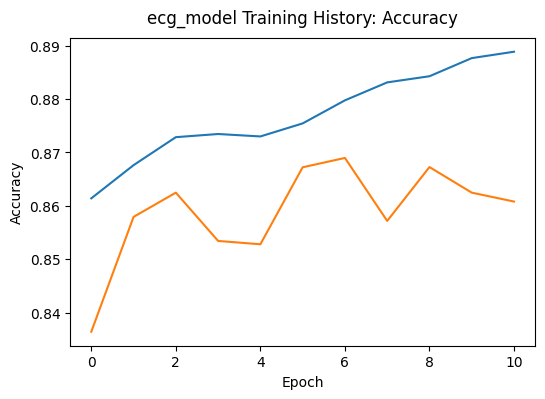

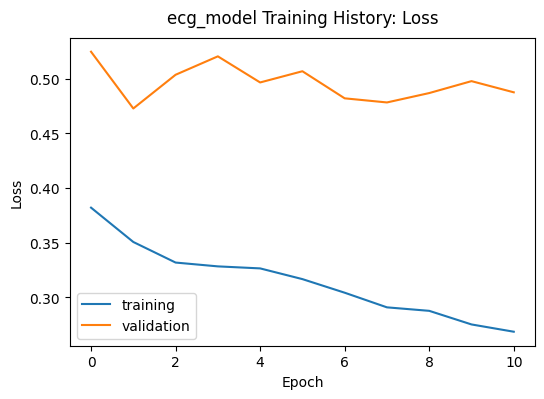

In [ ]:
plot_accuracy(history_1,'ecg_model')
plot_loss(history_1, 'ecg_model')